# MNIST Digit Classification Project - Python Code

Steve Desilets

October 8, 2023

## 1) Introduction

For this project, we will be constructing models capable of classifying images of hand-drawn digits as the appropriate number (from 0 throuh 9).  To achieve this objective, we will construct several artificial neural network (ANN) models, an ANN model that leverages input data derived from principal components analysis (PCA), and a Random Forest Classifier model. For each of these models, we'll examine performance metrics as well as the key features that the models extracted during the training process.

## 2) Importing Data, Conducting Exploratory Data Analysis, and Cleaning Data

### 2.1) Notebook Set-Up and Data Importation

First, let's download the necessary packages.

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as k

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.12.0


Now let's mount to the Google Colab environment.

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Let's define functions that will be useful throughout the model development and assessment process.

In [4]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

Let's load the MNIST dataset into this Python notebook.

The MNIST dataset of handwritten digits has a training set of 60,000 images, and a test set of 10,000 images. It comes prepackaged as part of `tf.Keras`. We will load this dataset and the corresponding labels as Numpy arrays.

* Tuples of Numpy arrays: `(x_train, y_train)`, `(x_test, y_test)`
* `x_train`, `x_test`: uint8 arrays of grayscale image data with shapes (num_samples, 28, 28).
* `y_train`, `y_test`: uint8 arrays of digit labels (integers in range 0-9)

In [6]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 3s 0us/step


### 2.2) Exploratory Data Analysis

Let's perform exploratory data analysis on the imported MNIST data.

Let's examine the shape of our datasets.

In [7]:
print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

x_train:	(60000, 28, 28)
y_train:	(60000,)
x_test:		(10000, 28, 28)
y_test:		(10000,)


Let's print the first 10 labels in our training and test datasets.

In [8]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [5 0 4 1 9 2 1 3 1 4]



In [9]:
print("First ten labels training dataset:\n {}\n".format(y_test[0:10]))

First ten labels training dataset:
 [7 2 1 0 4 1 4 9 5 9]



Let's examine the distribution of label values in our training and test datasets.

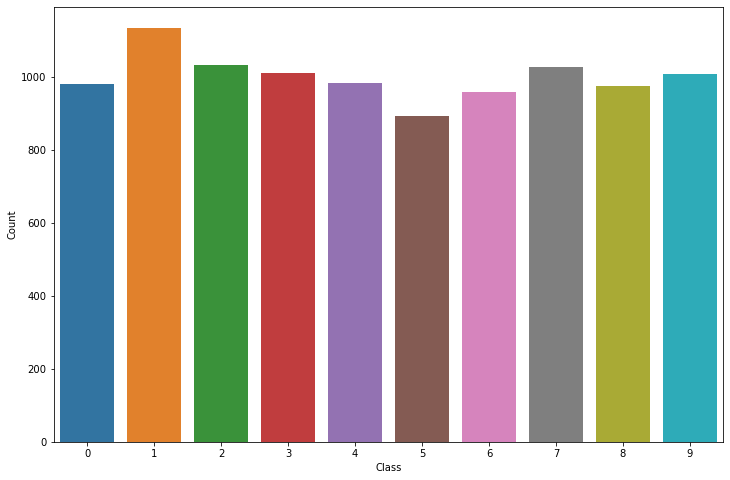

In [10]:
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(y_test).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

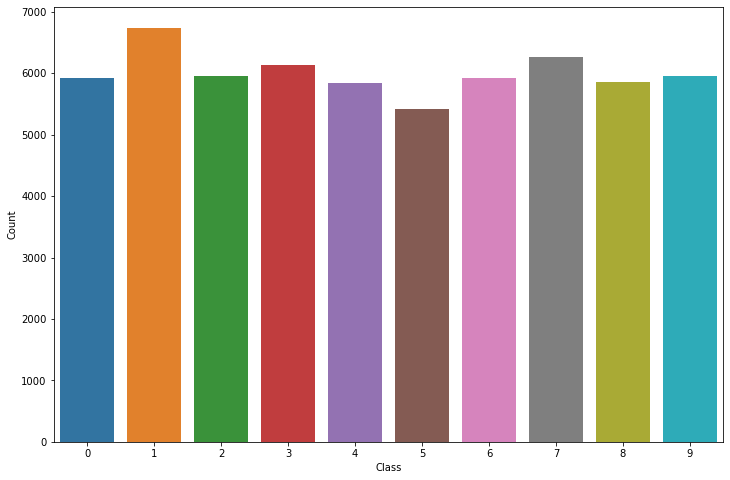

In [11]:
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(y_train).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

In [12]:
Counter(y_train).most_common()

[(1, 6742),
 (7, 6265),
 (3, 6131),
 (2, 5958),
 (9, 5949),
 (0, 5923),
 (6, 5918),
 (8, 5851),
 (4, 5842),
 (5, 5421)]

In [13]:
Counter(y_test).most_common()

[(1, 1135),
 (2, 1032),
 (7, 1028),
 (3, 1010),
 (9, 1009),
 (4, 982),
 (0, 980),
 (8, 974),
 (6, 958),
 (5, 892)]

Let's examine the first fifty images in the training and test datasets.

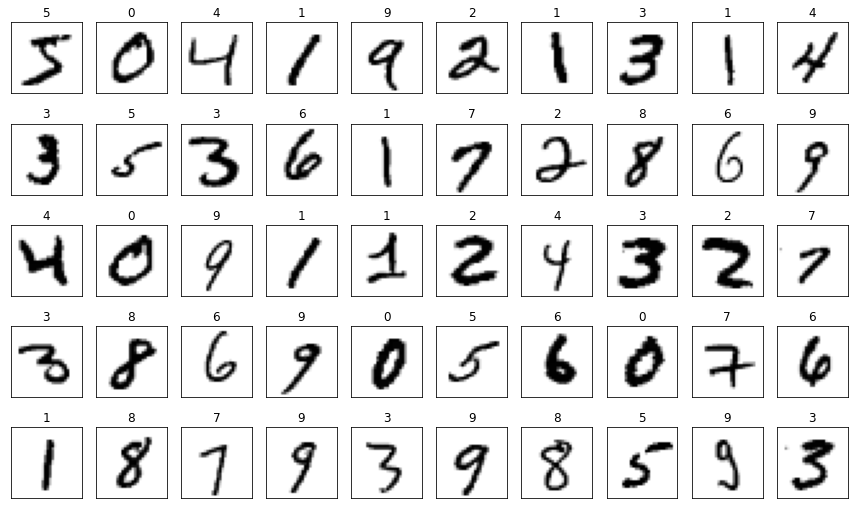

In [14]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='binary')

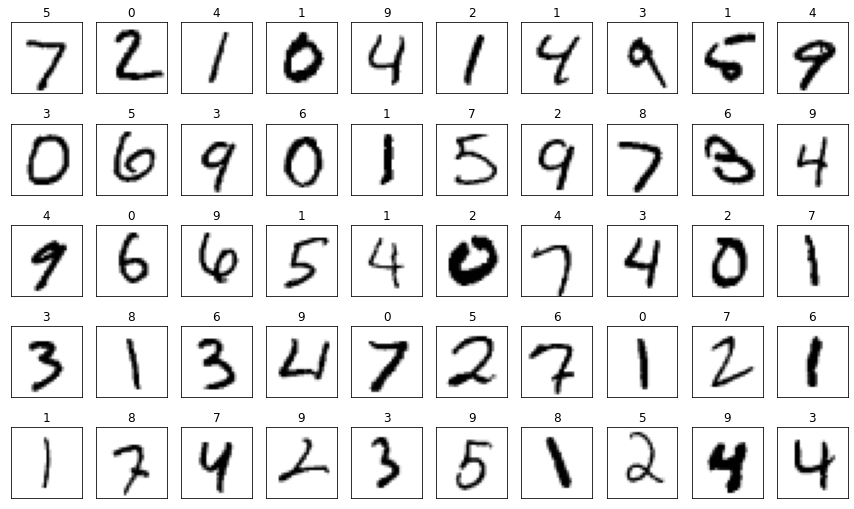

In [15]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[i].reshape(28,28), cmap='binary')

### 2.3) Data Cleaning and Pre-Processing

* Before we build our model, we need to prepare the data into the shape the network expected
* More specifically, we will convert the labels (integers 0 to 9) to 1D numpy arrays of shape (10,) with elements 0s and 1s.
* We also reshape the images from 2D arrays of shape (28,28) to 1D *float32* arrays of shape (784,) and then rescale their elements to values between 0 and 1.

##### Let's apply one-hot coding to the labels.

We will change the way the labels are represented from numbers (0 to 9) to vectors (1D arrays) of shape (10, ) with all the elements set to 0 except the one which the label belongs to - which will be set to 1. For example:


| original label | one-hot encoded label |
|------|------|
| 5 | [0 0 0 0 0 1 0 0 0 0] |
| 7 | [0 0 0 0 0 0 0 1 0 0] |
| 1 | [0 1 0 0 0 0 0 0 0 0] |

In [16]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:10,]))

print("First ten entries of y_test:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_test:\n {}".format(y_train_encoded[0:10,]))

First ten entries of y_train:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
First ten entries of y_test:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_test:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [17]:
print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)

y_train_encoded shape:  (60000, 10)
y_test_encoded shape:  (10000, 10)


##### Reshape the images to 1D arrays

Reshape the images from shape (28, 28) 2D arrays to shape (784, ) vectors (1D arrays).

In [18]:
# Before reshape:
print('x_train:\t{}'.format(x_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))

x_train:	(60000, 28, 28)
x_test:		(10000, 28, 28)


In [19]:
np.set_printoptions(linewidth=np.inf)
print("{}".format(x_train[2020]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 167 208  19   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  13 235 254  99   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  74 254 234   4   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 154 254 145   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 224 254  92   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  51 245 211  13   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   2 169 254 101   0   0   0   0   0   

In [20]:
# Reshape the images:
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))

# After reshape:
print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)

x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)


1. Each element in an image is a pixel value
2. Pixel values range from 0 to 255
3. 0 = White
4. 255 = Black

Let's review thew unique values using the set from the first image in the training dataset.

In [21]:
print(set(x_train_reshaped[0]))

{0, 1, 2, 3, 9, 11, 14, 16, 18, 23, 24, 25, 26, 27, 30, 35, 36, 39, 43, 45, 46, 49, 55, 56, 64, 66, 70, 78, 80, 81, 82, 90, 93, 94, 107, 108, 114, 119, 126, 127, 130, 132, 133, 135, 136, 139, 148, 150, 154, 156, 160, 166, 170, 171, 172, 175, 182, 183, 186, 187, 190, 195, 198, 201, 205, 207, 212, 213, 219, 221, 225, 226, 229, 238, 240, 241, 242, 244, 247, 249, 250, 251, 252, 253, 255}


##### Rescale the elements of the reshaped images

Let's rescale the elements of the x_train_reshaped and x_test_reshaped datasets to be between 0 and 1. 

In [22]:
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

In [23]:
# Take a look at the first reshaped and normalized training image:
print(set(x_train_norm[0]))
print(set(x_test_norm[0]))

{0.0, 0.011764706, 0.53333336, 0.07058824, 0.49411765, 0.6862745, 0.101960786, 0.6509804, 1.0, 0.96862745, 0.49803922, 0.11764706, 0.14117648, 0.36862746, 0.6039216, 0.6666667, 0.043137256, 0.05490196, 0.03529412, 0.85882354, 0.7764706, 0.7137255, 0.94509804, 0.3137255, 0.6117647, 0.41960785, 0.25882354, 0.32156864, 0.21960784, 0.8039216, 0.8666667, 0.8980392, 0.7882353, 0.52156866, 0.18039216, 0.30588236, 0.44705883, 0.3529412, 0.15294118, 0.6745098, 0.88235295, 0.99215686, 0.9490196, 0.7647059, 0.2509804, 0.19215687, 0.93333334, 0.9843137, 0.74509805, 0.7294118, 0.5882353, 0.50980395, 0.8862745, 0.105882354, 0.09019608, 0.16862746, 0.13725491, 0.21568628, 0.46666667, 0.3647059, 0.27450982, 0.8352941, 0.7176471, 0.5803922, 0.8117647, 0.9764706, 0.98039216, 0.73333335, 0.42352942, 0.003921569, 0.54509807, 0.67058825, 0.5294118, 0.007843138, 0.31764707, 0.0627451, 0.09411765, 0.627451, 0.9411765, 0.9882353, 0.95686275, 0.83137256, 0.5176471, 0.09803922, 0.1764706}
{0.0, 0.32941177, 0.59

## 3) Experiment 1 - ANN with 1 Hidden Layer with 1 Node

### 3.1) Construct Model

Now that we've finished preprocessing our MNIST image data, let's construct our first artificial neural network to classify images as integers.

In [24]:
k.clear_session()

model = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 785       
                                                                 
 output_layer (Dense)        (None, 10)                20        
                                                                 
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [27]:
#tf.keras.model.fit
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

#tf.keras.callbacks.EarlyStopping
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


history = model.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1500/1500 [==============================] - 4s 2ms/step - loss: 1.9747 - accuracy: 0.2235 - val_loss: 1.8265 - val_accuracy: 0.2640
Epoch 2/200
1500/1500 [==============================] - 4s 2ms/step - loss: 1.7803 - accuracy: 0.2721 - val_loss: 1.7258 - val_accuracy: 0.2867
Epoch 3/200
1500/1500 [==============================] - 3s 2ms/step - loss: 1.7188 - accuracy: 0.2820 - val_loss: 1.6852 - val_accuracy: 0.2799
Epoch 4/200
1500/1500 [==============================] - 4s 2ms/step - loss: 1.6923 - accuracy: 0.2839 - val_loss: 1.6639 - val_accuracy: 0.2797


### 3.2) Evaluate Model Performance on Testing Dataset

Now that we've fit our model, let's apply the model to the test dataset and subsequently evaluate its performance.

In [28]:
model = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.6821 - accuracy: 0.2848
Test acc: 0.285


In [ ]:
# loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)
# print('test set accuracy: ', accuracy * 100)

In [29]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 2ms/step
shape of preds:  (10000, 10)


As part of our model evaluation, let's look at the first 25 images by plotting the test set images along with their predicted and actual labels to understand how the trained model actually performed on specific example images.

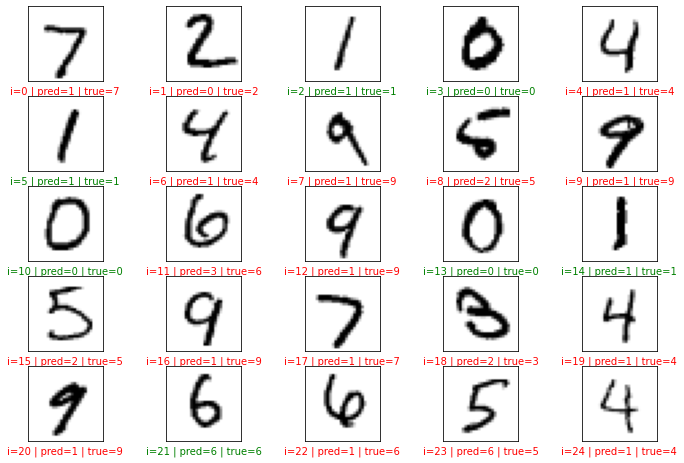

In [30]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

Let's use `Matplotlib` to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [31]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [33]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,1.975,0.224,1.827,0.264
1,1.780,0.272,1.726,0.287
2,1.719,0.282,1.685,0.280
3,1.692,0.284,1.664,0.280


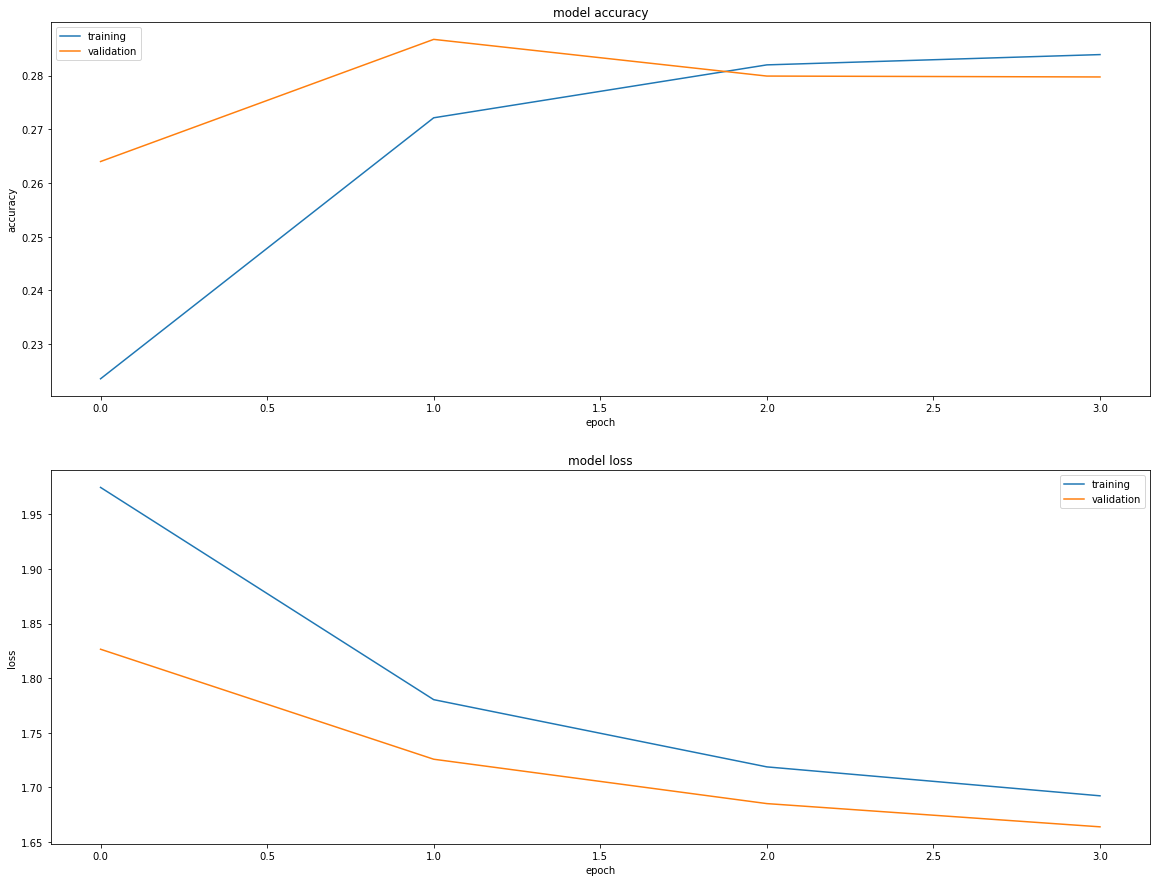

In [34]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

Let's examine precision and recall performance metrics for each of the prediction classes.

In [35]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 0s 1ms/step


In [36]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.51      0.90      0.65       980
           1       0.26      0.96      0.40      1135
           2       0.24      0.44      0.31      1032
           3       0.21      0.11      0.14      1010
           4       0.13      0.01      0.01       982
           5       0.00      0.00      0.00       892
           6       0.20      0.32      0.25       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.28     10000
   macro avg       0.15      0.27      0.18     10000
weighted avg       0.16      0.28      0.18     10000

Accuracy Score: 0.2848
Root Mean Square Error: 4.199488064038282


C:\Users\steve\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\steve\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\steve\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Let's create a table that visualizes the model output for each of the first 20 images. These outputs can be thought of as the model's expression of the probability that each image corresponds to each digit class.

In [37]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_norm), axis=-1)
pred_classes;

313/313 [==============================] - 1s 2ms/step


<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [38]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [39]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9
0,0.13%,24.64%,3.38%,2.25%,19.84%,1.36%,2.03%,22.29%,3.41%,20.66%
1,45.04%,0.00%,7.13%,12.42%,0.00%,15.65%,13.88%,0.00%,5.87%,0.00%
2,0.13%,24.64%,3.38%,2.25%,19.84%,1.36%,2.03%,22.29%,3.41%,20.66%
3,61.19%,0.00%,4.29%,8.71%,0.00%,12.33%,10.07%,0.00%,3.42%,0.00%
4,0.13%,24.64%,3.38%,2.25%,19.84%,1.36%,2.03%,22.29%,3.41%,20.66%
5,0.13%,24.64%,3.38%,2.25%,19.84%,1.36%,2.03%,22.29%,3.41%,20.66%
6,0.13%,24.64%,3.38%,2.25%,19.84%,1.36%,2.03%,22.29%,3.41%,20.66%
7,0.13%,24.64%,3.38%,2.25%,19.84%,1.36%,2.03%,22.29%,3.41%,20.66%
8,3.05%,2.88%,19.95%,17.29%,3.71%,12.79%,16.52%,1.57%,19.06%,3.17%
9,0.13%,24.64%,3.38%,2.25%,19.84%,1.36%,2.03%,22.29%,3.41%,20.66%


Let's create a confusion matrix that visualizes the model's performance on the testing data.

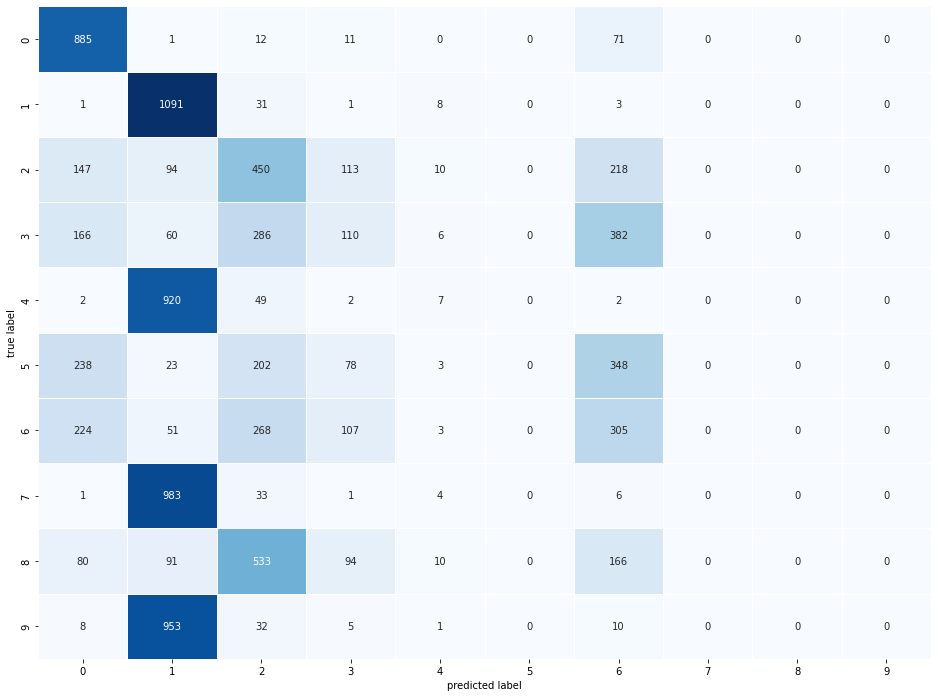

In [40]:
plot_confusion_matrix(y_test,pred_classes)

It looks like 107 sixes were misclassified as threes (and 382 threes were misclassified as sixes). We display some of these misclassfications along with an examination of ones and sevens that were correctly identified.



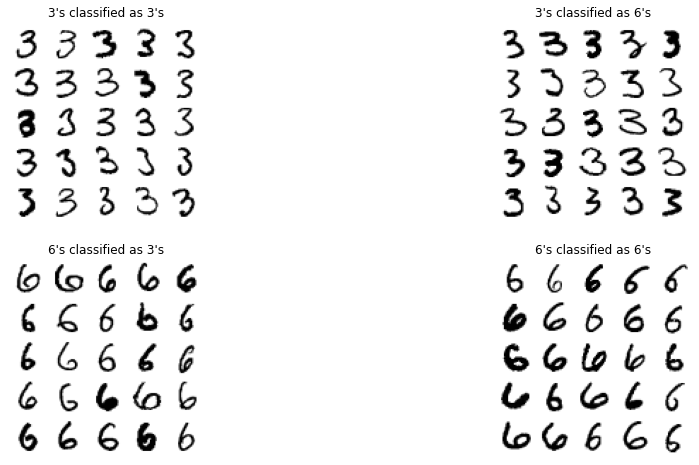

In [42]:
cl_a, cl_b = 3, 6
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)]
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)]
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)]
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(16,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

### 3.3) Examine Model Activation Values

To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [43]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 2 layers


In [44]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image

1875/1875 [==============================] - 4s 2ms/step


(60000, 1)

In [45]:
output_layer_activations.shape

(60000, 10)

In [46]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 19.110580444335938


In [47]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (60000, 10)
The output for the first image are [0.196 0.    0.136 0.179 0.    0.183 0.188 0.    0.119 0.   ]
The sum of the probabilities is (approximately) 0.9999999403953552


In [49]:
#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,1):
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.000,0.000,4.0,1.0,9.0,2.000,1.0,3.000,1.0,4.0,3.000,5.00,3.000,6.000,1.0
act_val_0,5.535,8.896,0.0,0.0,0.0,1.957,0.0,4.675,0.0,0.0,3.441,2.57,5.146,3.106,0.0


Let's visualize these activiation values via boxplots.

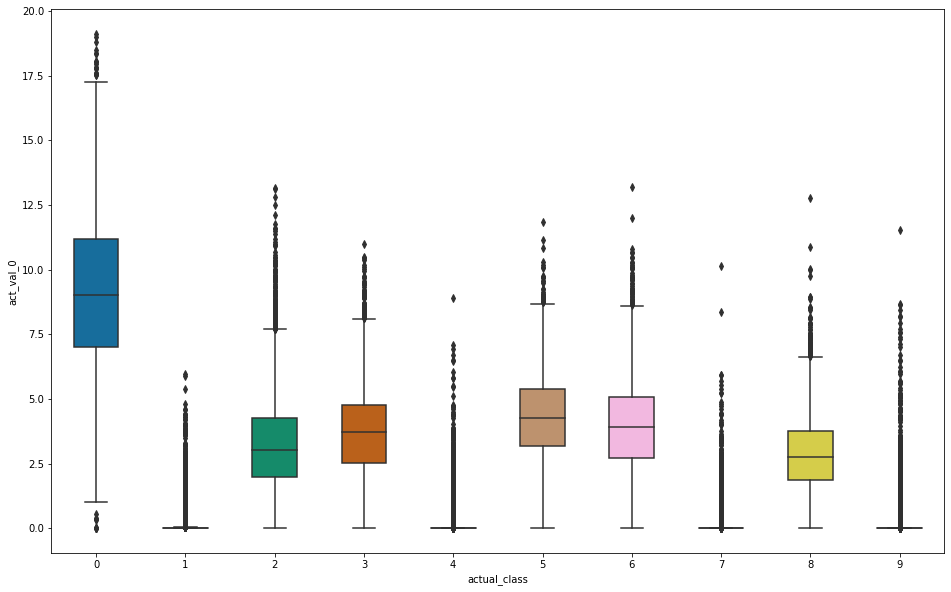

In [50]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
plt.figure(figsize=(16,10))
bplot = sns.boxplot(y='act_val_0', x='actual_class',
                 data=activation_df[['act_val_0','actual_class']],
                 width=0.5,
                 palette="colorblind")

In [51]:
activation_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

,actual_class,range_of_act_values
0,0,"[0.0, 19.11]"
1,1,"[0.0, 5.95]"
2,2,"[0.0, 13.17]"
3,3,"[0.0, 10.97]"
4,4,"[0.0, 8.9]"
5,5,"[0.0, 11.83]"
6,6,"[0.0, 13.2]"
7,7,"[0.0, 10.16]"
8,8,"[0.0, 12.75]"
9,9,"[0.0, 11.51]"


Let's get activation values of the pixel values.

We can create a dataframe with the pixel values and class labels

In [52]:
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':y_train}
for k in range(0,784):
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.0,0.0,4.0,1.0,9.0,2.0,1.0,3.0,1.0,4.0,3.0,5.0,3.0,6.0,1.0
pix_val_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pix_val_779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
pixel_df.pix_val_77.value_counts()

0.000000    59720
1.000000       25
0.996078       13
0.992157        9
0.050980        6
            ...  
0.894118        1
0.690196        1
0.725490        1
0.517647        1
0.819608        1
Name: pix_val_77, Length: 150, dtype: int64

In [54]:
pixel_df.pix_val_78.value_counts()

0.000000    59862
1.000000        6
0.960784        4
0.992157        4
0.141176        4
            ...  
0.556863        1
0.584314        1
0.427451        1
0.078431        1
0.501961        1
Name: pix_val_78, Length: 97, dtype: int64

Use a scatter plot to visualize the predicive power of the pixel values at two fixed locations in the image, i.e. how well the pixel values at two fixed locations in the image "predict" the class labels.

We use a scatter plot to determine the correlation between the `pix_val_77` and `pix_val_78` values and the `actual_class` values.

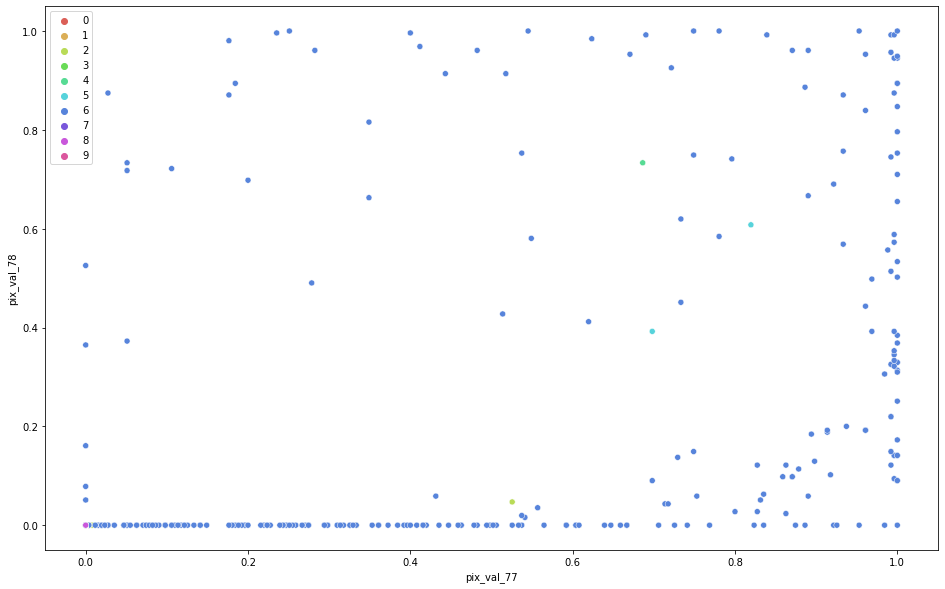

In [55]:
plt.figure(figsize=(16, 10))
color = sns.color_palette("hls", 10)
sns.scatterplot(x="pix_val_77", y="pix_val_78", hue="actual_class",  palette=color, data = pixel_df, legend="full")
plt.legend(loc='upper left');

## 4) Experiment 2 - ANN with 1 Hidden Layer with 2 Nodes

## 5)  Experiment 3 - ANN with 1 Hidden Layer with ______________________ Nodes

## 6) Experiment 4 - ANN with 1 Hidden Layer with ___________________ Nodes

## 7) Experiment 5 - ANN with 1 Hidden Layer with _________________________________ Nodes

## 8) Experiment 6 - ANN with 1 Hidden Layer with _______________________________ Nodes

## 9) Experiment 7 - ANN with 1 Hidden Layer with ____________________________ Nodes

## 10) Experiment 8 - ANN with 1 Hidden Layer with __________________________ Nodes

## 11) Experiment 9 - Principal Components Analysis Followed By Artificial Neural Network

## 12) Experiment 10 - Random Forest Classifier 